<a href="https://colab.research.google.com/github/Kraw-ller/QFT/blob/main/q-facial%20recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 13.5 MB/s eta 0:00:00


In [23]:
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 61.0 MB/s eta 0:00:00


In [43]:
!pip install qiskit[visualization]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.6 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136818 sha256=cf1ccb550d050ccc17bd851833e9afaf731ad2969ce2021e00fba2c31a366476
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [2]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import matplotlib.tri as plttri

from qiskit import *
from qiskit.extensions import Initialize

import itertools
import random

In [3]:
from google.colab import files
uploaded = files.upload()


Saving FFHQ.zip to FFHQ.zip


In [4]:
import zipfile
import io

# Replace 'uploaded_file.zip' with the actual name of your uploaded zip file
with zipfile.ZipFile(io.BytesIO(uploaded['FFHQ.zip']), 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [5]:
def load_images_in_folder(folder, label):
    """load all the images (file ending with .png) within the given folder. Expects the image filename is a five digits code
    'xxxxx' and that the file 'xxxxx_landmarks.json' exists within the same folder. Return a structure containing for each image:
    the path of the image, the given label, the set of landmark points."""
    container = []
    # get a list of all files ending with '.png' within the given folder
    images = filter(lambda f: f.endswith('.png'), os.listdir(folder))
    # for each png file:
    for filename in images:
        # get the id, which is the filename without extension
        id = os.path.splitext(filename)[0]
        # calculate the path of the corrisponding landmark points file
        landmarks_path = "{}/{:05d}_landmarks.json".format(folder, int(id))
        # add the current item into the container
        container.append({
            "image": "{}/{}".format(folder, filename),
            "label": label,
            "landmarks": json.load(open(landmarks_path))
        })
    return container

faces_dataset = []
faces_dataset += load_images_in_folder("FFHQ/happy", "happy")
faces_dataset += load_images_in_folder("FFHQ/sad", "sad")

In [6]:
def visualize_image(face):

    image = pltimg.imread(face["image"])
    x, y = zip(*face["landmarks"]) # divide the list of (x,y) tuple in the list of x's and y's

    plt.figure(figsize=(8, 6), dpi=80) # set width of figure
    plt.imshow(image) # show image
    plt.scatter(x, y, color='red') # overlay the landmark points in red over the image
    plt.show() # show picture

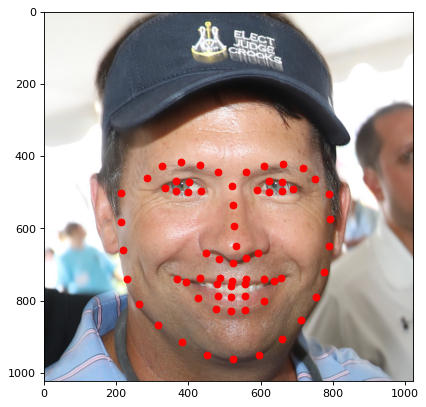

In [7]:
visualize_image(faces_dataset[3])

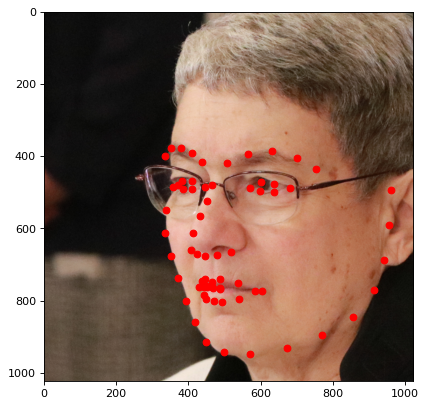

In [8]:
visualize_image(faces_dataset[13])



*   complete graph encoding: each pair of vertices has an
edge between them;
*   hordal graph encoding: the graph is chordal and built with the Delaunay triangulation algorithm, which assures that each vertex has at least two edges and every induced cycle in the graph has exactly three vertices.


In [9]:
def build_complete_graph(the_coordinates):
    """Given a list of N items in form (x,y), return the N*N matrix representing
    the weighted undirected graph whose vertices are the points, an edge exists
    between each couple of points and is labelled with the distance between them"""
    N = len(the_coordinates) # find the number of coordinates
    graph = np.zeros((N,N))  # create an N*N matrix initializated to zero
    # for each couple of points calculate the distance:
    for i, point_i in enumerate(the_coordinates):
        for j, point_j in enumerate(the_coordinates):
            distance = np.linalg.norm(np.asarray(point_i) - np.asarray(point_j))
            graph[i][j] = distance
            graph[j][i] = distance
    return graph

def build_chordal_graph(the_coordinates):
    """Given a list of N items in form (x,y), return the N*N matrix representing
    the weighted undirected graph whose vertices are the points, an edge exists
    between the couple of points decided by the Delaunay triangulation procedure,
    and is labelled with the distance between them"""
    N = len(the_coordinates)            # find the number of coordinates
    graph = np.zeros((N,N))             # create an N*N matrix initializated to zero
    x, y = zip(*the_coordinates)        # split (x,y) into array of x's and array of y's
    triang = plttri.Triangulation(x, y) # calculate Delaunay triangulation
    # for each edge decided by the Delaunay triangulation procedure:
    for edge in triang.edges:
        i, j = edge[0], edge[1]
        point_i, point_j = the_coordinates[i], the_coordinates[j]
        distance = np.linalg.norm(np.asarray(point_i) - np.asarray(point_j))
        graph[i][j] = distance
        graph[j][i] = distance
    return graph

In [10]:
def pick_upper_triangular_wo_diagonal(matrix):
    """Given an N*N matrix, return a vector of (N-1)*(N-2) elements containing the items of the input matrix in the upper triangular without diagonal positions"""
    N, _ = matrix.shape
    return matrix[np.triu_indices(N, k=1)] # k=1 removes the diagonal

In [11]:
def classical_distance(G_happy, G_sad, G_test, tol=0.00001):
    """Receives in input the three instances as numpy array of equal length, optionally a tolerance
    for equality operation and outputs
    HAPPY if happy_instance is closer to test_instance than to sad_instance else
    SAD if happy_instance is further from test_instance than from sad_instance else
    EQUAL if happy_instance and sad_instance are equally distant by test_instance"""

    # distance between the test instance and the happy instance
    distance_happy = np.linalg.norm(G_happy - G_test)

    # distance between the test instance and the sad instance
    distance_sad = np.linalg.norm(G_sad - G_test)

    # the difference is = 0 if the distance is equal, > 0 if sad is closest, < 0 if happy is closest
    difference = distance_happy - distance_sad

    # remove some numerical error that can classify numbers like +-0.00001 as Y1 or Y0 instead of EQUALS
    the_difference = 0 if np.abs(difference) <= tol else difference

    # sign(difference) = 0 -> EQUAL; sign(difference) = 1 -> SAD; sign(difference) = -1 -> HAPPY
    return difference, ["EQUAL", "SAD", "HAPPY"][int(np.sign(the_difference))]

In [12]:
def zero_padding(vector, qubits):
    """Given a complex vector of size n, adds up zeros until size 2**qubits is reached"""
    zeros = np.zeros((2**qubits,), dtype=np.cdouble)
    zeros[:len(vector)] = vector
    return zeros

In [13]:
def normalize(vector):
    """Return the normalized input vector"""
    max_iter = 10
    while np.linalg.norm(vector) != 1.0 and max_iter > 0:
        vector = vector / np.linalg.norm(vector)
        max_iter -= 1
    return vector

In [14]:
def controlled_initialize(normalized_vector, control_qubits):
    # create the circuit for initialization with leading Reset gates
    initialize_circuit = Initialize(normalized_vector)
    # gates_to_uncompute inverts the circuit, removing the Reset gates
    # and by inverting again we obtain the initialization circuit w/o Reset
    initialize_circuit_wo_reset = initialize_circuit.gates_to_uncompute().inverse()
    # return controlled version of the gate
    return initialize_circuit_wo_reset.control(control_qubits)

In [15]:
def quantum_distance_circuit(G_happy, G_sad, G_test):
    """Create the quantum circuit for classification"""
    # calculate how many qubits are needed for the data register
    qubit_per_feature = int(np.ceil(np.log2(len(G_happy))))
    # zero padding and normalization
    x_0 = normalize(zero_padding(G_happy, qubit_per_feature))
    x_1 = normalize(zero_padding(G_sad, qubit_per_feature))
    x_test = normalize(zero_padding(G_test, qubit_per_feature))
    # define the registers
    qr_auxiliary = QuantumRegister(1, 'anc')
    qr_index = QuantumRegister(1, 'index')
    qr_data = QuantumRegister(qubit_per_feature, 'data')
    qr_class = QuantumRegister(1, 'class')
    cr_auxiliary = ClassicalRegister(1, 'cr_anc')
    cr_class = ClassicalRegister(1, 'cr_class')
    # initialize the circuit
    qc = QuantumCircuit(qr_auxiliary, qr_index, qr_data, qr_class, cr_auxiliary, cr_class)
    # initialize index and data registers
    qc.h([0, 1])
    qc.append(controlled_initialize(x_test, 1), [qr_auxiliary[0]] + qr_data[:])
    qc.x(0)
    qc.append(controlled_initialize(x_0, 2), [qr_auxiliary[0], qr_index[0]] + qr_data[:])
    qc.x(1)
    qc.append(controlled_initialize(x_1, 2), [qr_auxiliary[0], qr_index[0]] + qr_data[:])
    # correlate the index with the class
    qc.cx(qr_index[0], qr_class[0])
    # work on auxiliary
    qc.h(0)
    # measure
    qc.measure(qr_auxiliary[0], cr_auxiliary[0])
    qc.measure(qr_class[0], cr_class[0])
    return qc

In [16]:
def quantum_distance(G_happy, G_sad, G_test, tol=0.00001, backend=None):
    """Creates the quantum circuit, runs it and return the difference between the two distances and the expected label"""
    SHOTS = 10000
    qc = quantum_distance_circuit(G_happy, G_sad, G_test)
    # custom backend
    if backend is None:
        backend = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend, shots=SHOTS).result().get_counts()
    # add missing values
    keys = ['0 0', '0 1', '1 0', '1 1'] # LSB = auxiliary, MSB = Class
    for key in keys:
        if key not in counts:
            counts[key] = 0
    # calculate distance
    keep_auxiliary_zero = False # you can equivalently keep results having auxiliary = 0 or auxiliary = 1
    if keep_auxiliary_zero:
        distance_happy = counts['1 0']
        distance_sad   = counts['0 0']
    else:
        distance_happy = counts['0 1']
        distance_sad   = counts['1 1']
    difference = (distance_happy - distance_sad)/SHOTS
    the_difference = 0 if np.abs(difference) <= tol else difference
    return difference, ["EQUAL", "SAD", "HAPPY"][int(np.sign(the_difference))]

In [17]:
def pick_mouth_points(n_points):
    """Returns a numpy array containing 'n_points' numbers between 48 and 68-1 without repetitions, given 0 <= n_points <= 20."""
    MOUTH_START, MOUTH_END = 48, 68
    return np.sort(np.random.choice(range(MOUTH_START, MOUTH_END), n_points, replace=False))

In [18]:
def faces_classifier(happy_instance, sad_instance, test_instance, is_quantum=True, is_complete_graph=True, n_points=20, backend=None):

    # pick construction method
    construction_method = build_complete_graph if is_complete_graph else build_complete_graph

    # choose points
    chosen_points  = pick_mouth_points(n_points)
    happy_instance = np.array(happy_instance["landmarks"])[chosen_points]
    sad_instance   = np.array(sad_instance["landmarks"])[chosen_points]
    test_instance  = np.array(test_instance["landmarks"])[chosen_points]

    # calculate features
    feature_happy = pick_upper_triangular_wo_diagonal(construction_method(happy_instance))
    feature_sad = pick_upper_triangular_wo_diagonal(construction_method(sad_instance))
    feature_test = pick_upper_triangular_wo_diagonal(construction_method(test_instance))

    # classify
    if is_quantum:
        distance, label = quantum_distance(feature_happy, feature_sad, feature_test, backend=backend)
    else:
        distance, label = classical_distance(feature_happy, feature_sad, feature_test)

    return label

In [19]:
happy_dataset = load_images_in_folder("FFHQ/happy", "HAPPY")
sad_dataset   = load_images_in_folder("FFHQ/sad", "SAD")

N_TRAINING_ITEMS = 5
happy_training_set = happy_dataset[:N_TRAINING_ITEMS]
sad_training_set   = sad_dataset[:N_TRAINING_ITEMS]

happy_testing_set = happy_dataset[N_TRAINING_ITEMS:]
sad_testing_set   = sad_dataset[N_TRAINING_ITEMS:]
testing_set       = happy_testing_set + sad_testing_set

In [21]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [28]:
n_points          = 15 # from 1 to 20
is_complete_graph = True
is_quantum        = False

correct, wrong = 0, 0
for test_instance in testing_set:

    happy_instance = random.choice(happy_training_set)
    sad_instance   = random.choice(sad_training_set)

    label = faces_classifier(happy_instance, sad_instance, test_instance,
                             is_quantum=is_quantum,
                             is_complete_graph=is_complete_graph,
                             n_points=n_points)

    label = most_common(labels)

    if label == test_instance["label"]:
        correct += 1
        print(".", end="")
    else:
        wrong += 1
        print("X", end="")

print(f"\nWe have classified {correct} faces correctly and {wrong} faces wrongly")

XXXXX.....
We have classified 5 faces correctly and 5 faces wrongly


In [29]:
n_points          = 15 # from 1 to 20
is_complete_graph = True
is_quantum        = True
CLASSIFICATION_PER_ITEM = 3

correct, wrong = 0, 0
for test_instance in testing_set:

    labels = []
    for _ in range(CLASSIFICATION_PER_ITEM):
        happy_instance = random.choice(happy_training_set)
        sad_instance   = random.choice(sad_training_set)
        label = faces_classifier(happy_instance, sad_instance, test_instance,
                                 is_quantum=is_quantum,
                                 is_complete_graph=is_complete_graph,
                                 n_points=n_points)
        labels.append(label)

    label = most_common(labels)

    if label == test_instance["label"]:
        correct += 1
        print(".", end="")
    else:
        wrong += 1
        print("X", end="")

print(f"\nWe have classified {correct} faces correctly and {wrong} faces wrongly")

.X...XXX..
We have classified 6 faces correctly and 4 faces wrongly
